In [45]:
import numpy as np
import pandas as pd
import static_frame as sf 
import pyarrow as pa
import pyarrow.compute as pc

import pickle
import pyarrow
import matplotlib.pyplot as plt
import numpy as np
import timeit

def plot(data, labels, title, y_label):
    fig, ax = plt.subplots()
    #fig.set_size_inches(3.8, 2.7)

    bar_width = 0.15
    index = np.arange(len(labels))
    opacity = 0.6

    placement = 0
    for k, v in data.items():
        plt.bar(index+placement,
                v,
                bar_width,
                alpha=opacity, 
                #color='r', 
                label=k)
        placement += bar_width 
        

    plt.title(title, fontweight='bold')
    plt.ylabel(y_label, fontsize=10)
    plt.xticks(index + placement / len(list(data.keys())), labels, fontsize=10)
    plt.legend(fontsize=10, bbox_to_anchor=(1, 1))
    #plt.tight_layout()
    plt.yticks(fontsize=10)
    plt.savefig('plot-' + title + '.png', format='png')
    
import pandas as pd
def plot_test(filename, title, y_value, y_label):
    df = pd.read_csv(filename)
    df['method']=df['label'].map(lambda z: z.split('_')[0])
    df['rows']=df['label'].map(lambda z: tuple(map(int, z.split('_')[1:])))
    data = dict()
    df = df.sort_values('rows')
    for k, v2 in df.groupby('method'):
        g = v2.sort_index()[y_value].values.tolist()
        data[k]=g
    labels = []
    for k, _ in df.groupby('rows'):
        labels.append(f'({k[0]:_}, {k[1]})')
    #print(labels)
    #print(data)
    plot(data, labels, title, y_label)    

# A Beginner's Tour of Apache Arrow

# A Hypothetical Wish List

-  Highly Performant
-  Optimized memory footprint
-  Copy-on demand (or Zero-copy when possible)
-  Efficiently move/share data between multi-process boundaries 
-  Tabular representation 
-  Rich data types 
-  In-memory analytics 
-  Memory-mapped access
-  Distributed
-  Langage Agnostic (maybe you want to use Julia!)

# Tools We are already familiar with

## Numpy

# What makes Numpy fast?

-  Numpy Array stored in contiguous memory
-  Accessing elements in an array is constant time
-  Meta-data, Values isolation
-  Zero-copy slicing

In [9]:
array1 =  np.array([[1, 2, 3], 
                    [4, 5, 6], 
                    [7, 8, 9]])

print('strides =', array1.strides)
print(array1.dtype)


strides= (24, 8)
int64


In [10]:
array2 =  np.array([[1, 2, 3], 
                    [4, 5, 6], 
                    [7, 8, 9]]).T

print('strides =', array2.strides)
print(array1.dtype)

strides= (8, 24)
int64


In [13]:
array3 = np.array([['sec1', True, 100.],
                   ['sec2', False, 200.],
                   ['sec3', True, 300]], dtype=object)

print('strides =', array3.strides)
print(array3.dtype)

strides = (24, 8)
object


In [28]:
array4 = array2[0:2, 1:3]  # zero-copy memory view
array4

array([[4, 7],
       [5, 8]])

# A Hypothetical Wish List

### Numpy

-  Highly Performant
-  Optimized memory footprint
-  Numpy slicing - providing zero-copy views
-  Efficiently move(but, no sharing) data between multi-process boundaries
-  In-memory analytics (without notion of indices)
-  Memory-mapped access
-  Rich data types (via structured arrays) - Performance characteristics not the same


### No Support

-  Tabular representation 
-  Rich data types 
-  Distributed
-  Langage Agnostic (maybe you want to use Julia!)

# Tools We are already familiar with

## Numpy
## Static Frame / Pandas

# Static Frame / Pandas

# Things we gain

-  Tabular representation 
    -  Index/Index Hierarchy
    -  Columnar
-  Declarative in-memory analytics


# The trade-offs

-  Memory footprint higher than plain numpy
-  More expensive to move data between processes (compared to Numpy)

# A Hypothetical Wish List

### Numpy

-  Highly Performant
-  Optimized memory footprint
-  Efficiently move data between multi-process boundaries
-  In-memory analytics (without notion of indices)
-  Memory-mapped access
-  Rich data types (via structured arrays) - Performance characteristics not the same

### Pandas

-  Tabular representation 
-  Better in-memory analytics

### No Support

-  Rich data types 
-  Distributed
-  Langage Agnostic (maybe you want to use Julia!)

# Apache Arrow

- Specifies columnar-data representation (aiming speed and efficiency)
- Efficiently move data between processes/machines
- Logical types for Tabular representation
- Rich data type support (without compromising speed)
- Language agnostic representation

# Some trade-offs 

.. We will talk about them soon

# Apache Arrow - Data Types

-  Primitive DataType (int32, float64, string)
-  Array 

In [20]:
# PyArray 

py_array = pa.array([1, 2, 3, 4, 5], type=pa.int32())
py_array


[
  1,
  2,
  3,
  4,
  5
]

# Columnar Storage

array = [1, null, 2, 4, 8]


-------------------------------------------------------------------------------------------------------------------
```

* Length: 5, Null count: 1
* Validity bitmap buffer:

  |Byte 0 (validity bitmap) | Bytes 1-63            |
  |-------------------------|-----------------------|
  | 00011101                | 0 (padding)           |

* Value Buffer:

  |Bytes 0-3   | Bytes 4-7   | Bytes 8-11  | Bytes 12-15 | Bytes 16-19 | Bytes 20-63 |
  |------------|-------------|-------------|-------------|-------------|-------------|
  | 1          | unspecified | 2           | 4           | 8           | unspecified |
  
```
  
Source: https://arrow.apache.org/docs/format/Columnar.html

# Nested List Layout Example


array = [[12, -7, 25], null, [0, -127, 127, 50], []]

--------------------------------------------------

```
* Length: 4, Null count: 1
* Validity bitmap buffer:

  | Byte 0 (validity bitmap) | Bytes 1-63            |
  |--------------------------|-----------------------|
  | 00001101                 | 0 (padding)           |

* Offsets buffer (int32)

  | Bytes 0-3  | Bytes 4-7   | Bytes 8-11  | Bytes 12-15 | Bytes 16-19 | Bytes 20-63 |
  |------------|-------------|-------------|-------------|-------------|-------------|
  | 0          | 3           | 3           | 7           | 7           | unspecified |

* Values array (Int8array):
  * Length: 7,  Null count: 0
  * Validity bitmap buffer: Not required
  * Values buffer (int8)

    | Bytes 0-6                    | Bytes 7-63  |
    |------------------------------|-------------|
    | 12, -7, 25, 0, -127, 127, 50 | unspecified |
```

Source: https://arrow.apache.org/docs/format/Columnar.html

# Why is Columnar-Storage format important

- Efficient storage
- Fast lookup (offset based lookup)
- Easy to move around bytes (no serialization/deserialization required)
- Same performance characteristics for heteregenous data types
- Support for Rich data types without compromising on performance

# Record Batch (equivalent to Frames)

In [29]:
# all elements should be of same length
schema = pa.schema([('id', pa.int32()), 
                    ('name', pa.string()), 
                    ('is_valid', pa.bool_())])

data = [
    pa.array([1,2,3,4]),
    pa.array(['foo', 'bar','baz', None]),
    pa.array([True, None, False, True])
]
batch = pa.RecordBatch.from_arrays(data, schema=schema)

print(f'{batch.num_columns=}, \n{batch.num_rows=}, \n{batch.schema=}, \n\n{batch[1]=}')

batch.num_columns=3, 
batch.num_rows=4, 
batch.schema=id: int32
name: string
is_valid: bool, 

batch[1]=<pyarrow.lib.StringArray object at 0x7f9afc4a8fa0>
[
  "foo",
  "bar",
  "baz",
  null
]


In [37]:
print(batch[1])

print(batch[1:3][1]) # zero copy slicing

[
  "foo",
  "bar",
  "baz",
  null
]
[
  "bar",
  "baz"
]


# A Hypothetical Wish List

### Numpy

-  Highly Performant
-  Optimized memory footprint
-  Efficiently move data between multi-process boundaries
-  In-memory analytics (without notion of indices)
-  Memory-mapped access
-  Rich data types (via structured arrays) - Performance characteristics not the same

### Pandas

-  Tabular representation 
-  Better in-memory analytics 

### No Support

-  Rich data types 
-  Distributed
-  Langage Agnostic (maybe you want to use Julia!)

# A Hypothetical Wish List 

### PyArrow

-  Highly Performant
-  Optimized memory footprint
-  Efficiently move data between multi-process boundaries
-  Memory-mapped access
-  Rich data types (with same performance characteristics)
-  Distributed
-  Langage Agnostic (maybe you `can` use Julia!)

### Some Trade-offs

-  Tabular representation (lack of indices)
-  In-memory analytics (current API not very Pythonic)


# Performance Tests

# Performance Test 1

-  NxN Numpy Array
-  NxN PyArrow Array
-  Multi-process each column and calculate Sum


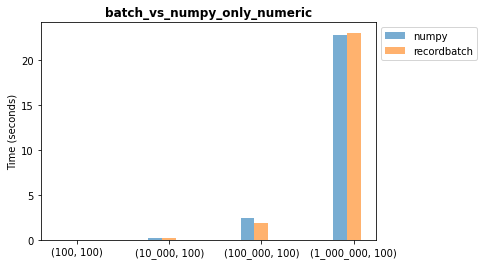

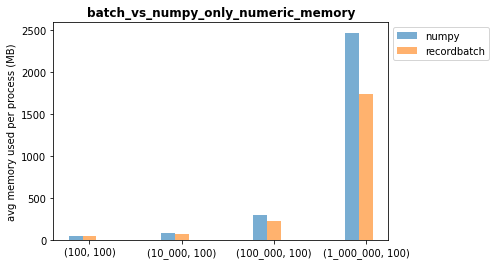

In [56]:
plot_test('/tmp/test1.txt', 'batch_vs_numpy_only_numeric', 'duration', 'Time (seconds)')
 
plot_test('/tmp/memory_test1.txt', 'batch_vs_numpy_only_numeric_memory', 'size', 'avg memory used per process (MB)')


# Performance Test 2

- Store `object` type in Numpy Array in 3 columns (int, bool, string)
- Same equivalent type in PyArrow Array in 3 columns (pyarrow.int, pyarrow.bool_, pyarrow.string)
- Measure performance across
     -  1_000_000 rows x 3 columns
     -  10_000_000 rows x 3 columns
     -  20_000_000 rows x 3 columns

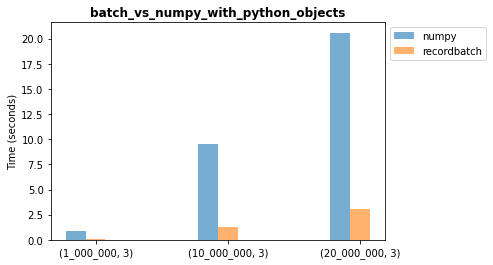

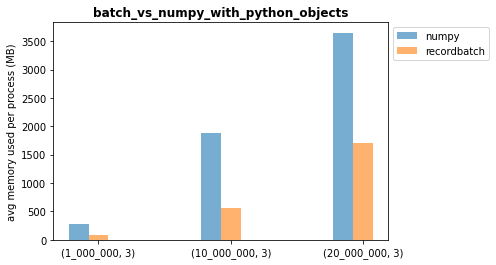

In [61]:
plot_test('test2.txt', 'batch_vs_numpy_with_python_objects', 'duration', 'Time (seconds)')
plot_test('memory_test2.txt', 'batch_vs_numpy_with_python_objects', 'size', 'avg memory used per process (MB)')


# Performance Test 3

-  Static Frame / Pandas with alternating bool/float types as columns
-  Similar columns in PyArrow
-  Measure performance across
    -  10_000 rows x 200 cols
    -  50_000 rows x 200 cols
    -  100_000 rows x 200 cols


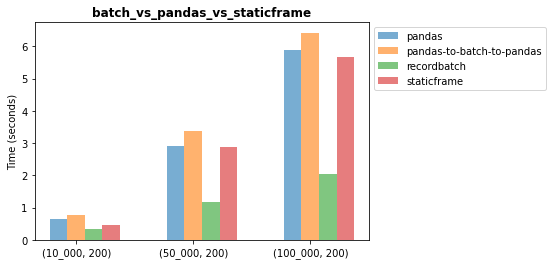

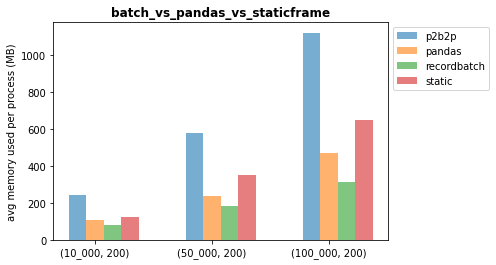

In [63]:
plot_test('test3.txt', 'batch_vs_pandas_vs_staticframe', 'duration', 'Time (seconds)')
plot_test('memory_test3.txt', 'batch_vs_pandas_vs_staticframe', 'size', 'avg memory used per process (MB)')


# Performance Test 4

-  Compare RecordBatch, ArrowFile and MappedArrowFile
-  Measure performance across
       - 10K - 1 million rows x 200 columns

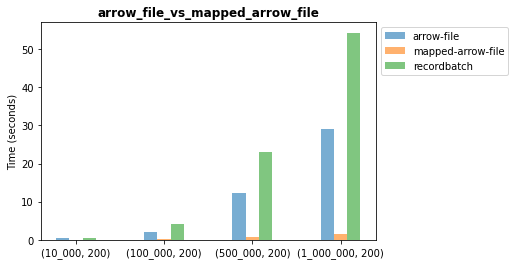

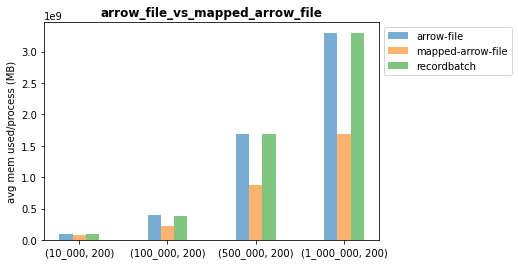

In [65]:
plot_test('test4.txt', 'arrow_file_vs_mapped_arrow_file', 'duration', 'Time (seconds)')
plot_test('memory_test4.txt', 'arrow_file_vs_mapped_arrow_file', 'size', 'avg mem used/process (MB)')


# Why not use Apache Arrow

# A Hypothetical Wish List 

### PyArrow

-  Highly Performant
-  Optimized memory footprint
-  Efficiently move data between multi-process boundaries
-  Memory-mapped access
-  Rich data types (with same performance characteristics)
-  Distributed
-  Langage Agnostic (maybe you `can` use Julia!)

### Some Trade-offs

-  Tabular representation (lack of indices)
-  In-memory analytics (current API not very Pythonic)
-  Linear Algebra operations

# Other related topics

-  Plasma store (sharing memory across processes)
-  Ray (similar to Plasma, but Python specific) 
-  Parquet and its relationship to Apache arrow


# Other Resources (for Performance Metrics)

1. Ray - https://arrow.apache.org/blog/2017/10/15/fast-python-serialization-with-ray-and-arrow/
2. Parquet - - https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet
3. Flight vs Parquet - https://ursalabs.org/blog/2020-feather-v2/

References

[apache-arrow-java] - (https://www.infoq.com/articles/apache-arrow-java/)

[pyarrow - Official Site] - (https://arrow.apache.org/docs/python/index.html)

[Apache Arrow and the Future of Data Frames" with Wes McKinney (2020)] - (https://www.youtube.com/watch?v=fyj4FyH3XdU)

[Apache Arrow - In Theory and Practice (2020)] - (https://www.youtube.com/watch?v=SFnkSReEjlk)

[Dremel (some ideas of Apache Arrow from here)]- (https://research.google/pubs/pub36632/)
